# Similarity search for motif mining

In this tutorial, we demonstrate how to utilize the similarity functionality to discover images with similar motifs from a collection of Reddit images. We employ the classic `SIFT` feature to identify images with a strikingly similar appearance (image-level pipeline).

Additionally, we extend the pipeline by incorporating an object detection model, `YOLO`, in combination with the SIFT feature. This enables us to identify objects within the images that exhibit a similar appearance (object-level similarity).

To illustrate the seamless integration of different vector stores, we leverage the power of multiple vector stores, namely `FAISS` and `QDRANT`, within evadb. This demonstrates the ease with which you can utilize diverse vector stores to construct indexes, enhancing your similarity search experience.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/11-similarity-search-for-motif-mining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/11-similarity-search-for-motif-mining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/raw/master/tutorials/11-similarity-search-for-motif-mining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB


In [1]:
%pip install --quiet "evadb[vision,document,notebook]"
%pip install --quiet kornia qdrant_client
import evadb
cursor = evadb.connect().cursor()
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Download reddit dataset

In [2]:
!wget -nc https://www.dropbox.com/scl/fo/fcj6ojmii0gw92zg3jb2s/h\?dl\=1\&rlkey\=j3kj1ox4yn5fhonw06v0pn7r9 -O reddit-images.zip
!unzip -o reddit-images.zip -d reddit-images

File ‘reddit-images.zip’ already there; not retrieving.
Archive:  reddit-images.zip
mapname:  conversion of  failed
 extracting: reddit-images/g348_d7jgzgf.jpg  
 extracting: reddit-images/g348_d7jphyc.jpg  
 extracting: reddit-images/g348_d7ju7dq.jpg  
 extracting: reddit-images/g348_d7jhhs3.jpg  
 extracting: reddit-images/g1074_d4n1lmn.jpg  
 extracting: reddit-images/g1074_d4mxztt.jpg  
 extracting: reddit-images/g1074_d4n60oy.jpg  
 extracting: reddit-images/g1074_d4n6fgs.jpg  
 extracting: reddit-images/g1190_cln9xzr.jpg  
 extracting: reddit-images/g1190_cln97xm.jpg  
 extracting: reddit-images/g1190_clna260.jpg  
 extracting: reddit-images/g1190_clna2x2.jpg  
 extracting: reddit-images/g1190_clna91w.jpg  
 extracting: reddit-images/g1190_clnad42.jpg  
 extracting: reddit-images/g1190_clnajd7.jpg  
 extracting: reddit-images/g1190_clnapoy.jpg  
 extracting: reddit-images/g1190_clnarjl.jpg  
 extracting: reddit-images/g1190_clnavnu.jpg  
 extracting: reddit-images/g1190_clnbalu.j

### Load all images into evadb

In [3]:
cursor.query("DROP TABLE IF EXISTS reddit_dataset;").df()
cursor.query("LOAD IMAGE 'reddit-images/*.jpg' INTO reddit_dataset;").df()

,0
0,Number of loaded IMAGE: 34


### Register a SIFT FeatureExtractor 
It uses `kornia` library to extract sift features for each image

In [4]:
cursor.query("DROP FUNCTION IF EXISTS SiftFeatureExtractor;").df()
cursor.query("""
    CREATE FUNCTION SiftFeatureExtractor
    IMPL '../evadb/functions/sift_feature_extractor.py'
""").df()

,0
0,Function SiftFeatureExtractor successfully add...


In [5]:
# Keep track of which image gets the most votes
from collections import Counter
vote = Counter()

## Image-level similarity search pipeline. 
This pipeline creates one vector per image. Next, we should breakdown steps how we build the index and search similar vectors using the index.

In [6]:
#1. Create index for the entire image
cursor.query("""DROP INDEX IF EXISTS reddit_sift_image_index""").df()
cursor.query("""
    CREATE INDEX reddit_sift_image_index 
    ON reddit_dataset (SiftFeatureExtractor(data)) 
    USING FAISS
""").df()

09-06-2023 16:13:31 WARNING[drop_object_executor:drop_object_executor.py:_handle_drop_index:0110] Index reddit_sift_image_index does not exist, therefore cannot be dropped.


,0
0,Index reddit_sift_image_index successfully add...


In [7]:
#2. Search similar vectors
response = cursor.query("""
    SELECT name FROM reddit_dataset ORDER BY
    Similarity(
      SiftFeatureExtractor(Open('reddit-images/g1074_d4mxztt.jpg')),
      SiftFeatureExtractor(data)
    )
    LIMIT 5
""").df()

In [8]:
#3. Update votes
for i in range(len(response)):
    vote[response["reddit_dataset.name"][i]] += 1
print(vote)

Counter({'reddit-images/g1074_d4mxztt.jpg': 1, 'reddit-images/g348_d7ju7dq.jpg': 1, 'reddit-images/g1209_ct6bf1n.jpg': 1, 'reddit-images/g1190_cln9xzr.jpg': 1, 'reddit-images/g1190_clna2x2.jpg': 1})


## Object-level similarity search pipeline. 
This pipeline detects objects within images and generates vectors exclusively from the cropped objects. The index is then constructed using these vectors. To showcase the versatility of `evadb`, we leverage `Qdrant` vector store specifically for building this index. This demonstrates how seamlessly you can leverage different vector stores within evadb.

### 1. Extract all the object using `Yolo` from the images

In [9]:
cursor.drop_table("reddit_object_table").df()
create_index_query = """
    CREATE TABLE IF NOT EXISTS reddit_object_table
    AS SELECT name, data, bboxes, labels FROM reddit_dataset
    JOIN LATERAL UNNEST(Yolo(data)) AS Obj(labels, bboxes, scores);"""
cursor.query(create_index_query).df()

""


### 2. Build an index on the feature vectors of the extracted objects

In [10]:
cursor.query("""
    CREATE INDEX reddit_sift_object_index
    ON reddit_object_table (SiftFeatureExtractor(Crop(data, bboxes)))
    USING QDRANT
""").df()

,0
0,Index reddit_sift_object_index successfully ad...


In [11]:
# Create a cropped images (We are actively working on features to allow
# us to not do this outside SQL)
response = (
    cursor.query(
        "LOAD IMAGE 'reddit-images/g1190_clna260.jpg' INTO reddit_search_image_dataset"
    )
    .df()
)
print(response)
response = (
    cursor.query("SELECT Yolo(data).bboxes FROM reddit_search_image_dataset;")
    .df()
)
print(response)


import cv2
import pathlib

bboxes = response["yolo.bboxes"][0]

img = cv2.imread("reddit-images/g1190_clna260.jpg")
pathlib.Path("reddit-images/search-object/").mkdir(parents=True, exist_ok=True)
for i, bbox in enumerate(bboxes):
    xmin, ymin, xmax, ymax = bbox
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    cropped_img = img[ymin:ymax, xmin:xmax]
    cv2.imwrite(f"reddit-images/search-object/search-{i}.jpg", cropped_img)


                           0
0  Number of loaded IMAGE: 1
                                         yolo.bboxes
0  [[257.2467956542969, 256.8749084472656, 457.67...


### 3. Retrieve using object-level similarity search

In [12]:
#4. 
import os

for path in os.listdir("reddit-images/search-object/"):
    path = "reddit-images/search-object/" + path
    query = f"""SELECT name FROM reddit_object_table ORDER BY
                        Similarity(
                          SiftFeatureExtractor(Open('{path}')),
                          SiftFeatureExtractor(data)
                        )
                        LIMIT 1"""
    response = cursor.query(query).df()
    for i in range(len(response)):
        vote[response["reddit_object_table.name"][i]] += 0.5

    print(response)

         reddit_object_table.name
0  reddit-images/g348_d7jgzgf.jpg
          reddit_object_table.name
0  reddit-images/g1190_cln9xzr.jpg
          reddit_object_table.name
0  reddit-images/g1190_cln9xzr.jpg


## Combine the scores from image level and object level similarity to show similar images

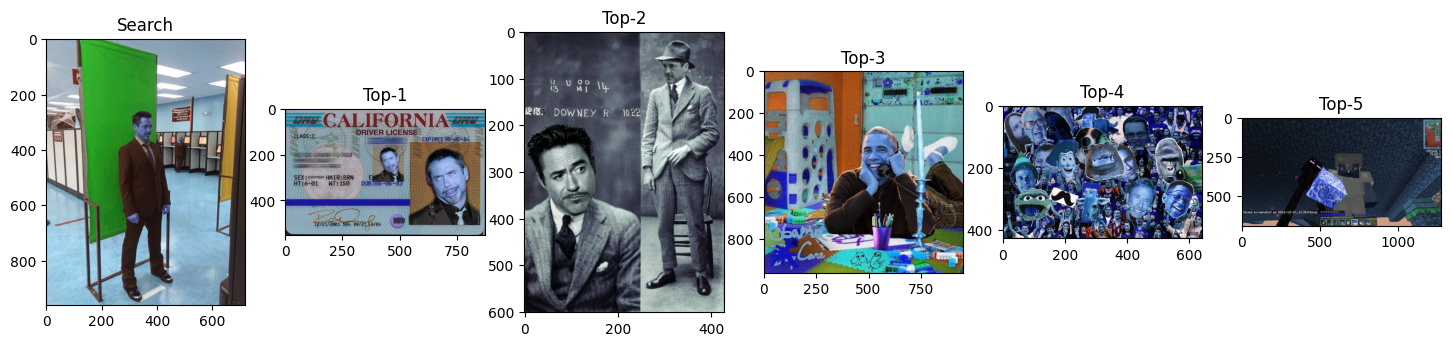

In [13]:
# !pip install matplotlib
import matplotlib.pyplot as plt

# Display top images
vote_list = list(reversed(sorted([(path, count) for path, count in vote.items()], key=lambda x: x[1])))
img_list = [path for path, _ in vote_list]

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=[18,10])
ax[0].imshow(cv2.imread("reddit-images/g1190_clna260.jpg"))
ax[0].set_title("Search")

for i in range(5):
    axi = ax[i + 1]
    img = cv2.imread(img_list[i])
    axi.imshow(img)
    axi.set_title(f"Top-{i + 1}")

plt.show()